## Implementation of Quantum Annealing Quasiparticle-NSM Hamiltonians using Ion-Q

In this notebook, we study and test the implementation of quantum adiabatic time evolution on several nuclei using the quasiparticle pairing approach on the Nuclear Shell Model Hamiltonians. First of all, we implement the target Hamiltonian.

#### Imports

In [1]:
import numpy as np
import json
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter
from src.qiskit_utils import get_hamiltonian

from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import SuzukiTrotter,QDrift
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import transpile
from qiskit.quantum_info import Statevector
import json


#### Build up the TARGET Hamiltonian, we get the parameters for the DRIVER Hamiltonian and finally we build up the unitary step circuit function.

##### Load the $g_{AB}$ coefficients for the specific Hamiltonian. In this particular case we explore only $^{6}He$, therefore we do not need any 2-body quasiparticle coefficients.

In [2]:
data_onebody=np.load('data/matrix_elements_h_eff_2body/one_body_nn_p.npz')
keys=data_onebody['keys']
values=data_onebody['values']
n_qubits=3

g_onebody={}

for a,key in enumerate(keys):
    i,j=key
    g_onebody[(i,j)]=values[a]

# print(t_onebody)
# t_onebody.pop((0,1))
# t_onebody.pop((0,2))
# t_onebody.pop((1,2))

print(g_onebody)


{(np.int64(0), np.int64(0)): np.float64(-8.4321), (np.int64(0), np.int64(1)): np.float64(1.0430999999999995), (np.int64(0), np.int64(2)): np.float64(-3.763858685577873), (np.int64(1), np.int64(0)): np.float64(1.0430999999999995), (np.int64(1), np.int64(1)): np.float64(-8.4321), (np.int64(1), np.int64(2)): np.float64(3.763858685577873), (np.int64(2), np.int64(0)): np.float64(-3.763858685577873), (np.int64(2), np.int64(1)): np.float64(3.763858685577873), (np.int64(2), np.int64(2)): np.float64(-5.1203)}


##### Here we get directly the driver Hamiltonian

In [3]:
coupling_term=-8.4321# this is the diagonal term of the H_T with the quasiparticle bitstring selected as in the paper
Z_tuples=[("Z", [0], -0.5*coupling_term)]
I_tuples=[('I',[0],0.5*coupling_term)]
# we need this dictionary to set the driver Hamiltonian in the unitary step of the QA algorithm
h_driver={0:coupling_term}
        
# We create the Hamiltonian as a SparsePauliOp, via the method
# `from_sparse_list`, and multiply by the interaction term.
hamiltonian_driver = SparsePauliOp.from_sparse_list([*Z_tuples,*I_tuples], num_qubits=n_qubits)


print(hamiltonian_driver)

SparsePauliOp(['IIZ', 'III'],
              coeffs=[ 4.21605+0.j, -4.21605+0.j])


##### Then, we get the Target Hamiltonian using the function

In [4]:
hamiltonian_target=get_hamiltonian(g_onebody,n_qubits)

print(hamiltonian_target)

SparsePauliOp(['IXX', 'XIX', 'XXI', 'IYY', 'YIY', 'YYI', 'IIZ', 'IZI', 'ZII', 'III'],
              coeffs=[  0.52155   +0.j,  -1.88192934+0.j,   1.88192934+0.j,   0.52155   +0.j,
  -1.88192934+0.j,   1.88192934+0.j,   4.21605   +0.j,   4.21605   +0.j,
   2.56015   +0.j, -10.99225   +0.j])


##### Define a function that builds up the quantum circuit



In [5]:
class QACircuit():
    
    def __init__(self, n_qubits, g_onebody, h_driver, total_time, n_steps):
        self.n_qubits = n_qubits
        self.g_onebody = g_onebody
        self.h_driver = h_driver
        self.total_time = total_time
        self.n_steps = n_steps
        self.dt = total_time / n_steps
        self.circuit = QuantumCircuit(n_qubits)



    def initialize_state(self, initial_state):
        """Initialize the quantum circuit to a given initial state.

        Args:
            initial_state (list): List of qubit indices to be set to |1>.
        """
        for qubit in initial_state:
            self.circuit.x(qubit)
    
    def build_circuit(self,save_energy=False,hamiltonian_target=None,hamiltonian_driver=None):
        for i in range(self.n_steps):
            t = i * self.dt
            if save_energy:
                # Add measurement to save energy at each step
                if i==0:
                    self.energy=[]
                self.energy.append(self.expectation_value((1-t/self.total_time)*hamiltonian_driver+t/self.total_time*hamiltonian_target))
            self.circuit.compose(self.unitary_step(t), inplace=True)


    def expectation_value(self, hamiltonian):
        """Calculate the expectation value of a Hamiltonian with respect to the circuit state.

        Args:
            hamiltonian (SparsePauliOp): The Hamiltonian operator.

        Returns:
            float: The expectation value.
        """
        statevector = Statevector(self.circuit)
        exp_val = statevector.expectation_value(hamiltonian)
        return exp_val.real

    def unitary_step(self,t):
        """Create the unitary step for the QA algorithm.

        Args:
            t (float): time parameter.
            
        Returns:
            QuantumCircuit: The unitary step circuit.
        """
        qc=QuantumCircuit(self.n_qubits)
        
        driver_d=(1-t/self.total_time)
        driver_t=t/self.total_time
        
        # driver Hamiltonian terms in the 1st order Trotterization
        for key in h_driver.keys():
            i=key
            coeff=self.dt*self.h_driver[key]*driver_d
            qc.rz(-0.5*coeff, i)
        
        
        # diagonal terms of the target Hamiltonian in the 1st order Trotterization
        for i in range(self.n_qubits):
            coeff=self.dt*self.g_onebody[(i,i)]*driver_t
            qc.rz(-0.5*coeff, i)

        # off diagonal terms of the target Hamiltonian in the 1st order Trotterization
        for i in range(self.n_qubits):
            for j in range(i+1,self.n_qubits):
                coeff=self.dt*self.g_onebody[(i,j)]*driver_t
                qc.rxx(0.5*coeff, i, j)
                qc.ryy(0.5*coeff, i, j)
            
        return qc
    
    
    def circuit_measure_z(self):
        """Add measurement in the Z basis to the circuit."""
        circuit_z=self.circuit.copy()
        circuit_z.measure_all()

        return circuit_z
    
    def circuit_measure_x(self):
        """Add measurement in the X basis to the circuit."""
        circuit_x=self.circuit.copy()
        for qubit in range(self.n_qubits):
            circuit_x.h(qubit)
        circuit_x.measure_all()
        return circuit_x
    
    def circuit_measure_y(self):
        """Add measurement in the Y basis to the circuit."""
        circuit_y=self.circuit.copy()
        for qubit in range(self.n_qubits):
            circuit_y.sdg(qubit)
            circuit_y.h(qubit)
        circuit_y.measure_all()
        return circuit_y
        

Let's try the QA circuit class using the statevector simulator

In [6]:
QAHe6=QACircuit(n_qubits, g_onebody, h_driver, total_time=5, n_steps=50)

QAHe6.initialize_state([0])  # Initialize to |100> state
QAHe6.build_circuit(save_energy=True, hamiltonian_target=hamiltonian_target,hamiltonian_driver=hamiltonian_driver)
# only for small circuits
#QAHe6.circuit.draw('mpl')

print(QAHe6.expectation_value(hamiltonian_target))

-12.986142243163531


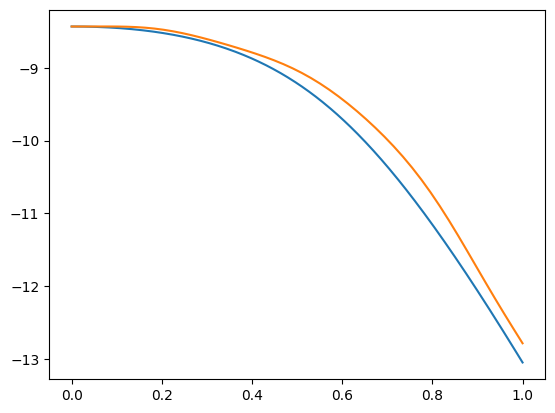

In [7]:
import matplotlib.pyplot as plt

data=np.load('data/6he_quasiparticle_qa.npz')
parameter=data['parameter']
energy=data['energy']

plt.plot(parameter,energy,label='QA classical simulation')
plt.plot(np.linspace(0,1,QAHe6.n_steps),np.asarray(QAHe6.energy),label='QA Quantum Circuit')

plt.show()

##### Let's transpile the quantum circuit using the Ion-Q backend

In [8]:
from qiskit_ionq import IonQProvider, GPI2Gate, MSGate

provider = IonQProvider()
backend_native = provider.get_backend("ionq_simulator", gateset="native")

ionq_circuit_transpiled=transpile(QAHe6.circuit, backend=backend_native,optimization_level=1)

print(ionq_circuit_transpiled.count_ops())

/home/ecosta/miniconda3/envs/qiskit-env/lib/python3.10/site-packages/qiskit_ionq/ionq_backend.py:127: IonQTranspileLevelWarning: Transpiler default optimization_level=2. IonQ (QIS) recommends 0-1 to avoid aggressive re-synthesis; use transpile(..., optimization_level=1).
  warn_bad_transpile_level()


OrderedDict([('gpi2', 5802), ('gpi', 1701), ('ms', 600)])


Cost of a $RXX + RYY$ gate in terms of primitive gates

In [9]:
c_rxx_ryy=QuantumCircuit(2)
c_rxx_ryy.rxx(0.3,0,1)
c_rxx_ryy.ryy(0.3,0,1)
c_rxx_ryy.draw('mpl')
ionq_c_rxx_ryy_transpiled=transpile(c_rxx_ryy, backend=backend_native,optimization_level=1)
print(ionq_c_rxx_ryy_transpiled.count_ops())

OrderedDict([('gpi2', 36), ('gpi', 10), ('ms', 4)])


So, consider that this gate takes $4$ non-local gates. The number of gates is $N_{qubit} \times (N_{qubit}-1) / 2$ therefore we have $4 \times 3=12$ per gate

##### Computation of the final energy

In [ ]:
from qiskit import QuantumCircuit, 
from qiskit_ionq import IonQProvider
from src.qiskit_utils import  obtain_frequencies_qiskit,get_shots_qiskit,compute_energy
provider = IonQProvider(token="3LIAGvfKIPYBGrhES6VujeFSTI3uwDWI")
noisy_backend = provider.get_backend("ionq_simulator")
noisy_backend.set_options(noise_model="forte-1")

shots=100

# get the circuits for each basis measurement
circuit_z=QAHe6.circuit_measure_z()
ionq_circuit_transpiled_z=transpile(circuit_z, backend=noisy_backend,optimization_level=2)

circuit_y=QAHe6.circuit_measure_y()
ionq_circuit_transpiled_y=transpile(circuit_y, backend=noisy_backend,optimization_level=2)

circuit_x=QAHe6.circuit_measure_x()
ionq_circuit_transpiled_x=transpile(circuit_x, backend=noisy_backend,optimization_level=2)

# Run the circuit on the IonQ simulator with forte-1 noise model
results = get_shots_qiskit(ionq_circuit_transpiled_x, ionq_circuit_transpiled_y, ionq_circuit_transpiled_z, shots=shots,backend=noisy_backend)


Results for basis X: {'000': 9, '001': 14, '010': 20, '011': 8, '100': 5, '101': 26, '110': 5, '111': 13}
Results for basis Y: {'000': 8, '001': 6, '010': 15, '011': 9, '100': 17, '101': 21, '110': 8, '111': 16}
Results for basis Z: {'000': 13, '001': 14, '010': 17, '011': 6, '100': 25, '101': 8, '110': 10, '111': 7}


Obtain the frequencies and correct using the symmetry sector projection

In [12]:
frequencies = obtain_frequencies_qiskit(results, shots=shots)


In [21]:

normalized_freqs_z={}
p_sector=0.
for key in frequencies['Z'].keys():
    print(key,np.sum(key))
    if np.sum(key)==-1:
        p_sector+=frequencies['Z'][key]
        normalized_freqs_z[key]=frequencies['Z'][key]
    else:
        normalized_freqs_z[key]=0.
print(p_sector)
# we need to normalize it again
for key in normalized_freqs_z.keys():
    normalized_freqs_z[key]/=p_sector

# remove the normalization due to the post-selection
frequencies['Z']=normalized_freqs_z

print(frequencies['Z'])

(np.float64(-1.0), np.float64(-1.0), np.float64(-1.0)) -3.0
(np.float64(-1.0), np.float64(-1.0), np.float64(1.0)) -1.0
(np.float64(-1.0), np.float64(1.0), np.float64(-1.0)) -1.0
(np.float64(-1.0), np.float64(1.0), np.float64(1.0)) 1.0
(np.float64(1.0), np.float64(-1.0), np.float64(-1.0)) -1.0
(np.float64(1.0), np.float64(-1.0), np.float64(1.0)) 1.0
(np.float64(1.0), np.float64(1.0), np.float64(-1.0)) 1.0
(np.float64(1.0), np.float64(1.0), np.float64(1.0)) 3.0
1.0
{(np.float64(-1.0), np.float64(-1.0), np.float64(-1.0)): 0.0, (np.float64(-1.0), np.float64(-1.0), np.float64(1.0)): 0.25, (np.float64(-1.0), np.float64(1.0), np.float64(-1.0)): 0.30357142857142855, (np.float64(-1.0), np.float64(1.0), np.float64(1.0)): 0.0, (np.float64(1.0), np.float64(-1.0), np.float64(-1.0)): 0.4464285714285714, (np.float64(1.0), np.float64(-1.0), np.float64(1.0)): 0.0, (np.float64(1.0), np.float64(1.0), np.float64(-1.0)): 0.0, (np.float64(1.0), np.float64(1.0), np.float64(1.0)): 0.0}


In [28]:
def compute_energy(frequencies, t_onebody,renormalization_factor=None):
    energy_component_z = 0.
    energy_component_y = 0.
    energy_component_x = 0.

    for (i, j), value in t_onebody.items():
        if i != j:    
            freq = frequencies['Y']
            for key in freq.keys():
                energy_component_y += 0.25 * value * key[i] * key[j] * freq[key]
                

            freq = frequencies['X']
            for key in freq.keys():
                energy_component_x += 0.25 * value * key[i] * key[j] * freq[key]        

        
        elif i == j:
            # convert projector from Z+I to I-Z
            freq = frequencies['Z']
            for key in freq.keys():
                energy_component_z += 0.5 * value * (key[i] + 1) * freq[key]
    
    # we add this renormalization factor to perform an approximate restoration of the symmetry sector
    if renormalization_factor is not None:
        print('bla bla')
        energy_component_y /=  renormalization_factor
        energy_component_x /=  renormalization_factor

    print(energy_component_x,energy_component_y,energy_component_z)

    return energy_component_x + energy_component_y + energy_component_z

In [29]:
energy = compute_energy(frequencies, g_onebody,renormalization_factor=p_sector)
print("Energy from IonQ simulator with forte-1 noise model:", energy)

bla bla
-1.3359523662406982 -0.5015578685577874 -7.60415
Energy from IonQ simulator with forte-1 noise model: -9.441660234798485
